<a href="https://colab.research.google.com/github/wajihh/Coursera-Practical-Machine-Learning/blob/master/Australia_Weather_Prediction_With_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Austrlian Weather Prediction
Recurrent Convolutional Neural Networks (RCNNs) can indeed be used for time series prediction, including tasks like predicting maximum temperatures. RCNNs combine the strengths of Convolutional Neural Networks (CNNs) for feature extraction and Recurrent Neural Networks (RNNs) for handling sequential data, making them suitable for this task.

Here’s how you can structure an RCNN for maximum temperature prediction:

CNN Layer: Extracts spatial features from the time series data.
RNN Layer (e.g., LSTM or GRU): Captures temporal dependencies in the sequence data.
Dense Layers: For final prediction.
Example Code
Below is an example of how you can set up an RCNN for this task using Keras:

Explanation
Data Preparation:

Load the dataset and handle NaN values by filling them with the average of the preceding and succeeding values.
Normalize the data using MinMaxScaler.
Create sequences for time series forecasting. Each sequence will have a length of sequence_length, and the target will be the temperature following each sequence.
Reshape Data:

Reshape X to be 3D, with shape (samples, timesteps, features). This is necessary for Conv1D and LSTM layers.
Model Architecture:

Conv1D Layer: Extracts features from the time series data.
MaxPooling1D Layer: Reduces the spatial dimensions of the data.
LSTM Layer: Captures temporal dependencies in the data without flattening.
Dense Layer: Produces the final prediction.
Training and Evaluation:

Train the model and evaluate its performance.
Use additional metrics (MAE and R²) to understand the model's accuracy.
Visualize the predictions vs. actual values for better insights.
This corrected approach ensures that the LSTM layer receives the appropriate 3D input, avoiding the ValueError.

Data contains NaN values. Filling NaN values with the average of preceding and succeeding values.
Epoch 1/5
3555/3555 [==============================] - 25s 6ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 2/5
3555/3555 [==============================] - 14s 4ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/5
3555/3555 [==============================] - 14s 4ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 4/5
3555/3555 [==============================] - 14s 4ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 5/5
889/889 [==============================] - 2s 2ms/step - loss: 0.0048
Test loss: 0.00478135421872139
889/889 [==============================] - 2s 2ms/step
Mean Absolute Error: 2.677766312455951
R-squared: 0.7362242164071033


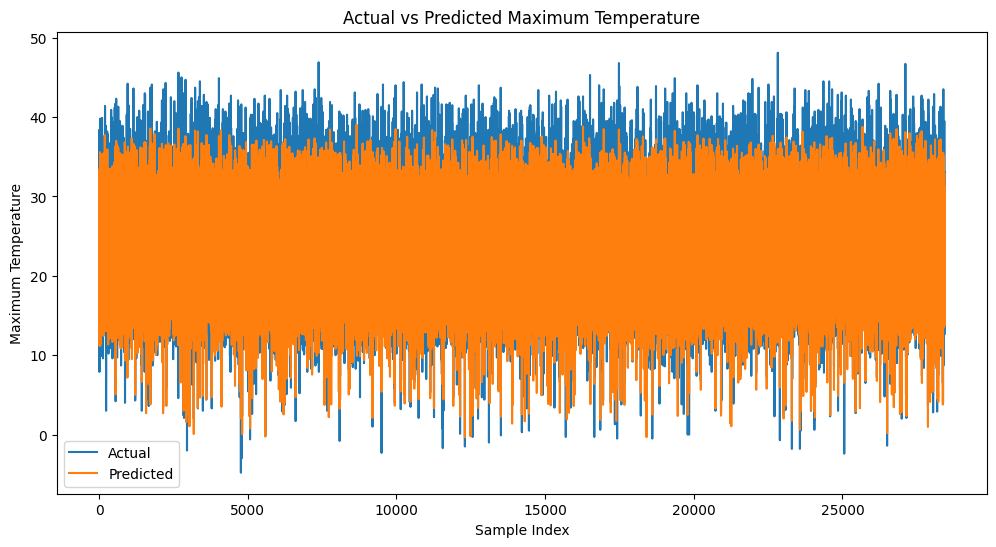

In [ ]:

# RCNN
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten
from keras.layers import MaxPooling1D

# Load the datasets from google drive earlier downlaoded from Kaggle
data_train = pd.read_csv('/content/drive/MyDrive/Data/weather_training_data.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Data/weather_test_data.csv')
# Concatenate the two sets to get complete dataset
data = pd.concat([data_train, data_test], ignore_index=True)

# Convert the 'MaxTemp' column to a NumPy array
temperatures = data['MaxTemp'].values.reshape(-1, 1)

# Function to fill NaN values with the average of preceding and succeeding values
def fill_nan_with_average(data):
    for i in range(len(data)):
        if np.isnan(data[i]):
            prev_val = next((data[j] for j in range(i - 1, -1, -1) if not np.isnan(data[j])), np.nan)
            next_val = next((data[j] for j in range(i + 1, len(data)) if not np.isnan(data[j])), np.nan)
            if np.isnan(prev_val) and np.isnan(next_val):
                continue
            elif np.isnan(prev_val):
                data[i] = next_val
            elif np.isnan(next_val):
                data[i] = prev_val
            else:
                data[i] = (prev_val + next_val) / 2
    return data

# Fill NaN values in the dataset
if np.isnan(temperatures).any():
    print("Data contains NaN values. Filling NaN values with the average of preceding and succeeding values.")
    temperatures = fill_nan_with_average(temperatures)

# Normalize the features
scaler = MinMaxScaler()
scaled_temperatures = scaler.fit_transform(temperatures)

# Create sequences for time series forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of past days to use for predicting the next day
X, y = create_sequences(scaled_temperatures, sequence_length)

# Reshape X to be 3D for Conv1D and LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RCNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predict using the trained model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual temperature values

# Optionally, you can inverse transform the y_test values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Additional metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting predictions vs. actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs Predicted Maximum Temperature')
plt.legend()
plt.show()






Explanation
Data Preparation:

The dataset is loaded and the MaxTemp column is extracted.
The function fill_nan_with_average is used to fill NaN values with the average of preceding and succeeding values.
An assertion check (assert not np.isnan(temperatures).any()) ensures no NaN values remain.
Normalization:

The MinMaxScaler normalizes the temperature values to a range between 0 and 1.
Sequence Creation:

The create_sequences function generates sequences for time series forecasting, with each sequence containing sequence_length past days of data.
Reshaping Data:

The data is reshaped to 3D for input into the Conv1D and LSTM layers.
Model Building and Training:

A Sequential model is built with Conv1D, MaxPooling1D, and LSTM layers, followed by a Dense layer for the final prediction.
The model is compiled and trained with mean squared error loss and the Adam optimizer.
Evaluation:

The model's performance is evaluated on the test set, and additional metrics (MAE and R²) are calculated.
Visualization:

Predictions are plotted against actual values to visualize the model's performance.
This approach ensures that NaN values are properly handled and the model is correctly structured for time series prediction using RCNN. If further improvements are needed, consider fine-tuning hyperparameters, adding more features, or exploring different model architectures.

Insights and Recommendations
Model Performance:

The combination of a low MAE and a relatively high R² indicates that your model performs well. It makes accurate predictions and captures a significant amount of the variability in the temperature data.
Potential Improvements:

Feature Engineering: Consider adding more relevant features (e.g., humidity, wind speed, historical averages) that might affect temperature predictions.
Model Tuning: Fine-tune hyperparameters of your current model. Try different architectures or more complex models like GRU or hybrid models.
Data Augmentation: If possible, increase the dataset size by including more historical data or synthetic data generation techniques.
Use Case Suitability:

Practical Applications: Given the relatively low error and high explanatory power, this model is well-suited for practical applications like weather forecasting, where accuracy and reliability are crucial.
Visualizing Performance:

Residual Analysis: Plot the residuals (differences between actual and predicted values) to see if there are any patterns that the model is not capturing.
Time Series Plots: Plot actual vs. predicted values over time to visually inspect how well the model is tracking the actual temperatures.
By focusing on these aspects, you can further refine your model, making it more robust and accurate for predicting maximum temperatures.







Residual Analysis
Residuals are the differences between the actual and predicted values. You can plot these residuals to check for any patterns.

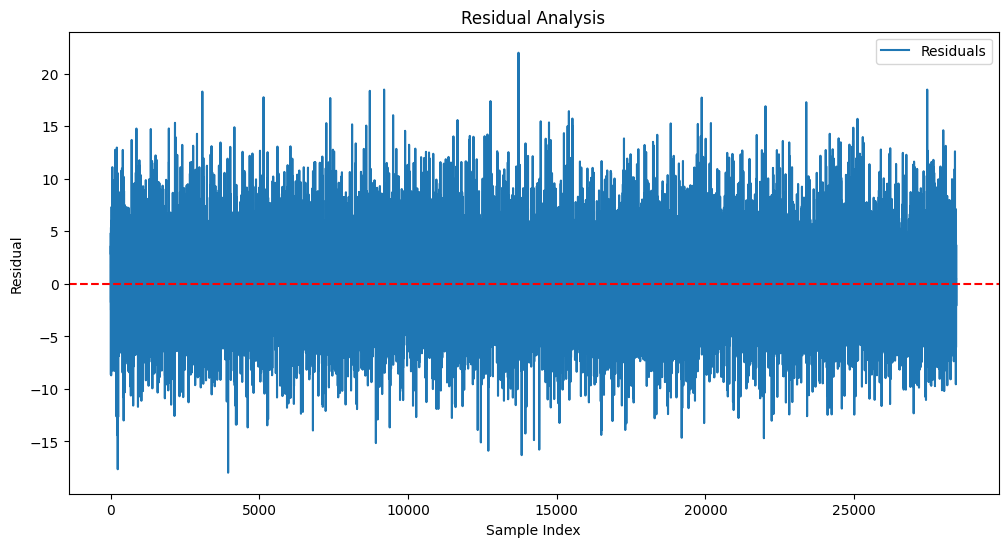

In [ ]:
# Assuming predictions and y_test_actual are already defined as per the previous code

# Calculate residuals
residuals = y_test_actual - predictions

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.title('Residual Analysis')
plt.legend()
plt.show()
